(section:dataset)=
# MUTAG Dataset

In this homework we will be working with the MUTAG dataset, a graph classification task where we aim to determine if a molecule is mutagenic or not.

## Loading the data
We simply use the Hugging Face API to retrieve the dataset; we will save it as a pickle for convenience.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append("../code")
import utils


In [3]:
dataset_hf = utils.load_dataset_mutag("./data/mutag.pickle")
dataset_hf

DatasetDict({
    train: Dataset({
        features: ['edge_index', 'node_feat', 'edge_attr', 'y', 'num_nodes'],
        num_rows: 188
    })
})

We see that the dataset consists of 188 graphs, each with certain attributes.

We have :
- `node_attr` : the node attributes, which represent the atom types in a one-hot encoded format.
- `edge_attr` : the edge attributes, which are the bond types, also one-hot encoded.
- `edge_index` : the edge indices, which are the connections between the nodes. This specifies all the from/to connections (edges).
- `y` : the target, which is a binary label indicating whether the molecule is mutagenic or not.
- `num_nodes` : the number of nodes in the graph. Can technically be inferred from `edge_index`.

In [4]:
dataset_hf.shape

{'train': (188, 5)}

In [5]:
edge_indices = dataset_hf["train"]["edge_index"] # contains lists of edges. first dim is the index of a node, e.g. 0, and it will appear as many times as it has edges. second dim is the index of the node it is connected to, e.g. 1
node_features = dataset_hf["train"]["node_feat"] # features of each node, as N_NODES x N_FEATURES (one-hot encoding of the atom type)
edges_attr = dataset_hf["train"]["edge_attr"] # attributes of each edge, as N_EDGES x N_EDGE_FEATURES (one-hot encoding of the bond type)
class_y = dataset_hf["train"]["y"] # class of each graph, as N_GRAPHS x 1.
num_nodes = dataset_hf["train"]["num_nodes"] # number of nodes in each graph, as N_GRAPHS x 1. Can be recovered from edge_indices technically 

Now let's look at the distribution of classes in the dataset:

In [6]:
uni = np.unique(class_y, return_counts=True)
print(f"{uni[1][0]} class 1 molecules and {uni[1][1]} class 2 molecules")
print(f"Percentage of class 1 molecules: {uni[1][0]/(uni[1][0]+uni[1][1])*100:.0f}%")
print(f"Percentage of class 2 molecules: {uni[1][1]/(uni[1][0]+uni[1][1])*100:.0f}%")

63 class 1 molecules and 125 class 2 molecules
Percentage of class 1 molecules: 34%
Percentage of class 2 molecules: 66%


While there is no explicit mention of which class is mutagenic, we will assume that class 1 is mutagenic and class 2 is not, since class 1 has far less molecules.

## Preprocessing - Adapting the data for training
When using the data, we will adapt the format for model training.

We will use :
- The **Adjacency matrix**, recovered from `edge_index` and padded up to the maximum number of nodes in the dataset.
  
  It will have shape $N \times N$, where $N$ is the maximum number of nodes in the dataset.
- The **Node features**, recovered from `node_attr` and padded up to the maximum number of nodes in the dataset.
  
  It will have shape $N \times F_{nodes}$, where $F_{nodes}$ is the number of features per node.

- Later, when using **Edge features**, we will obtain them from `edge_attr` and reshape them to $N \times N \times E_{feat}$, with $E_{feat}$ being the edge feature dimension. 
  
  This means we technically have both the adjacency matrix and the edge features in the same tensor, as non-connected nodes will have a zero feature vector. 

  Let us look at one such adjacency matrix, without padding for now :

In [7]:
adjacency_matrices = [utils.convert_edges_to_adjacency(edges) for edges in edge_indices]

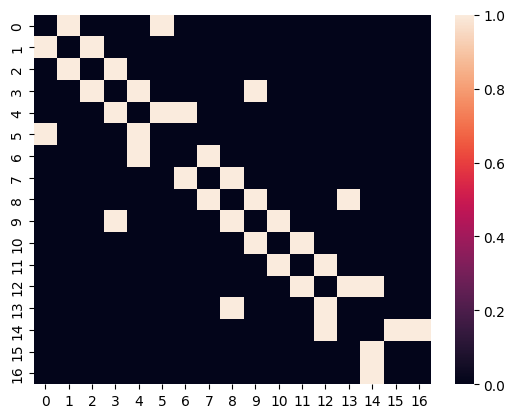

In [8]:
sns.heatmap(adjacency_matrices[0])
plt.show()

We see it corresponds to an undirected graph, as the adjacency matrix is symmetric; and it is not weighted, as all the values are 1.

Also, the diagonal is zero, so no self-loops.

## Molecule visualization

Let's plot some molecules from the dataset using `networkx`.

The Kamada-Kawai layout allows to more or less recover a molecule-looking shape, though it is not perfect.
We use the atom type for node color, and the edges width is proportional to the bond type. 

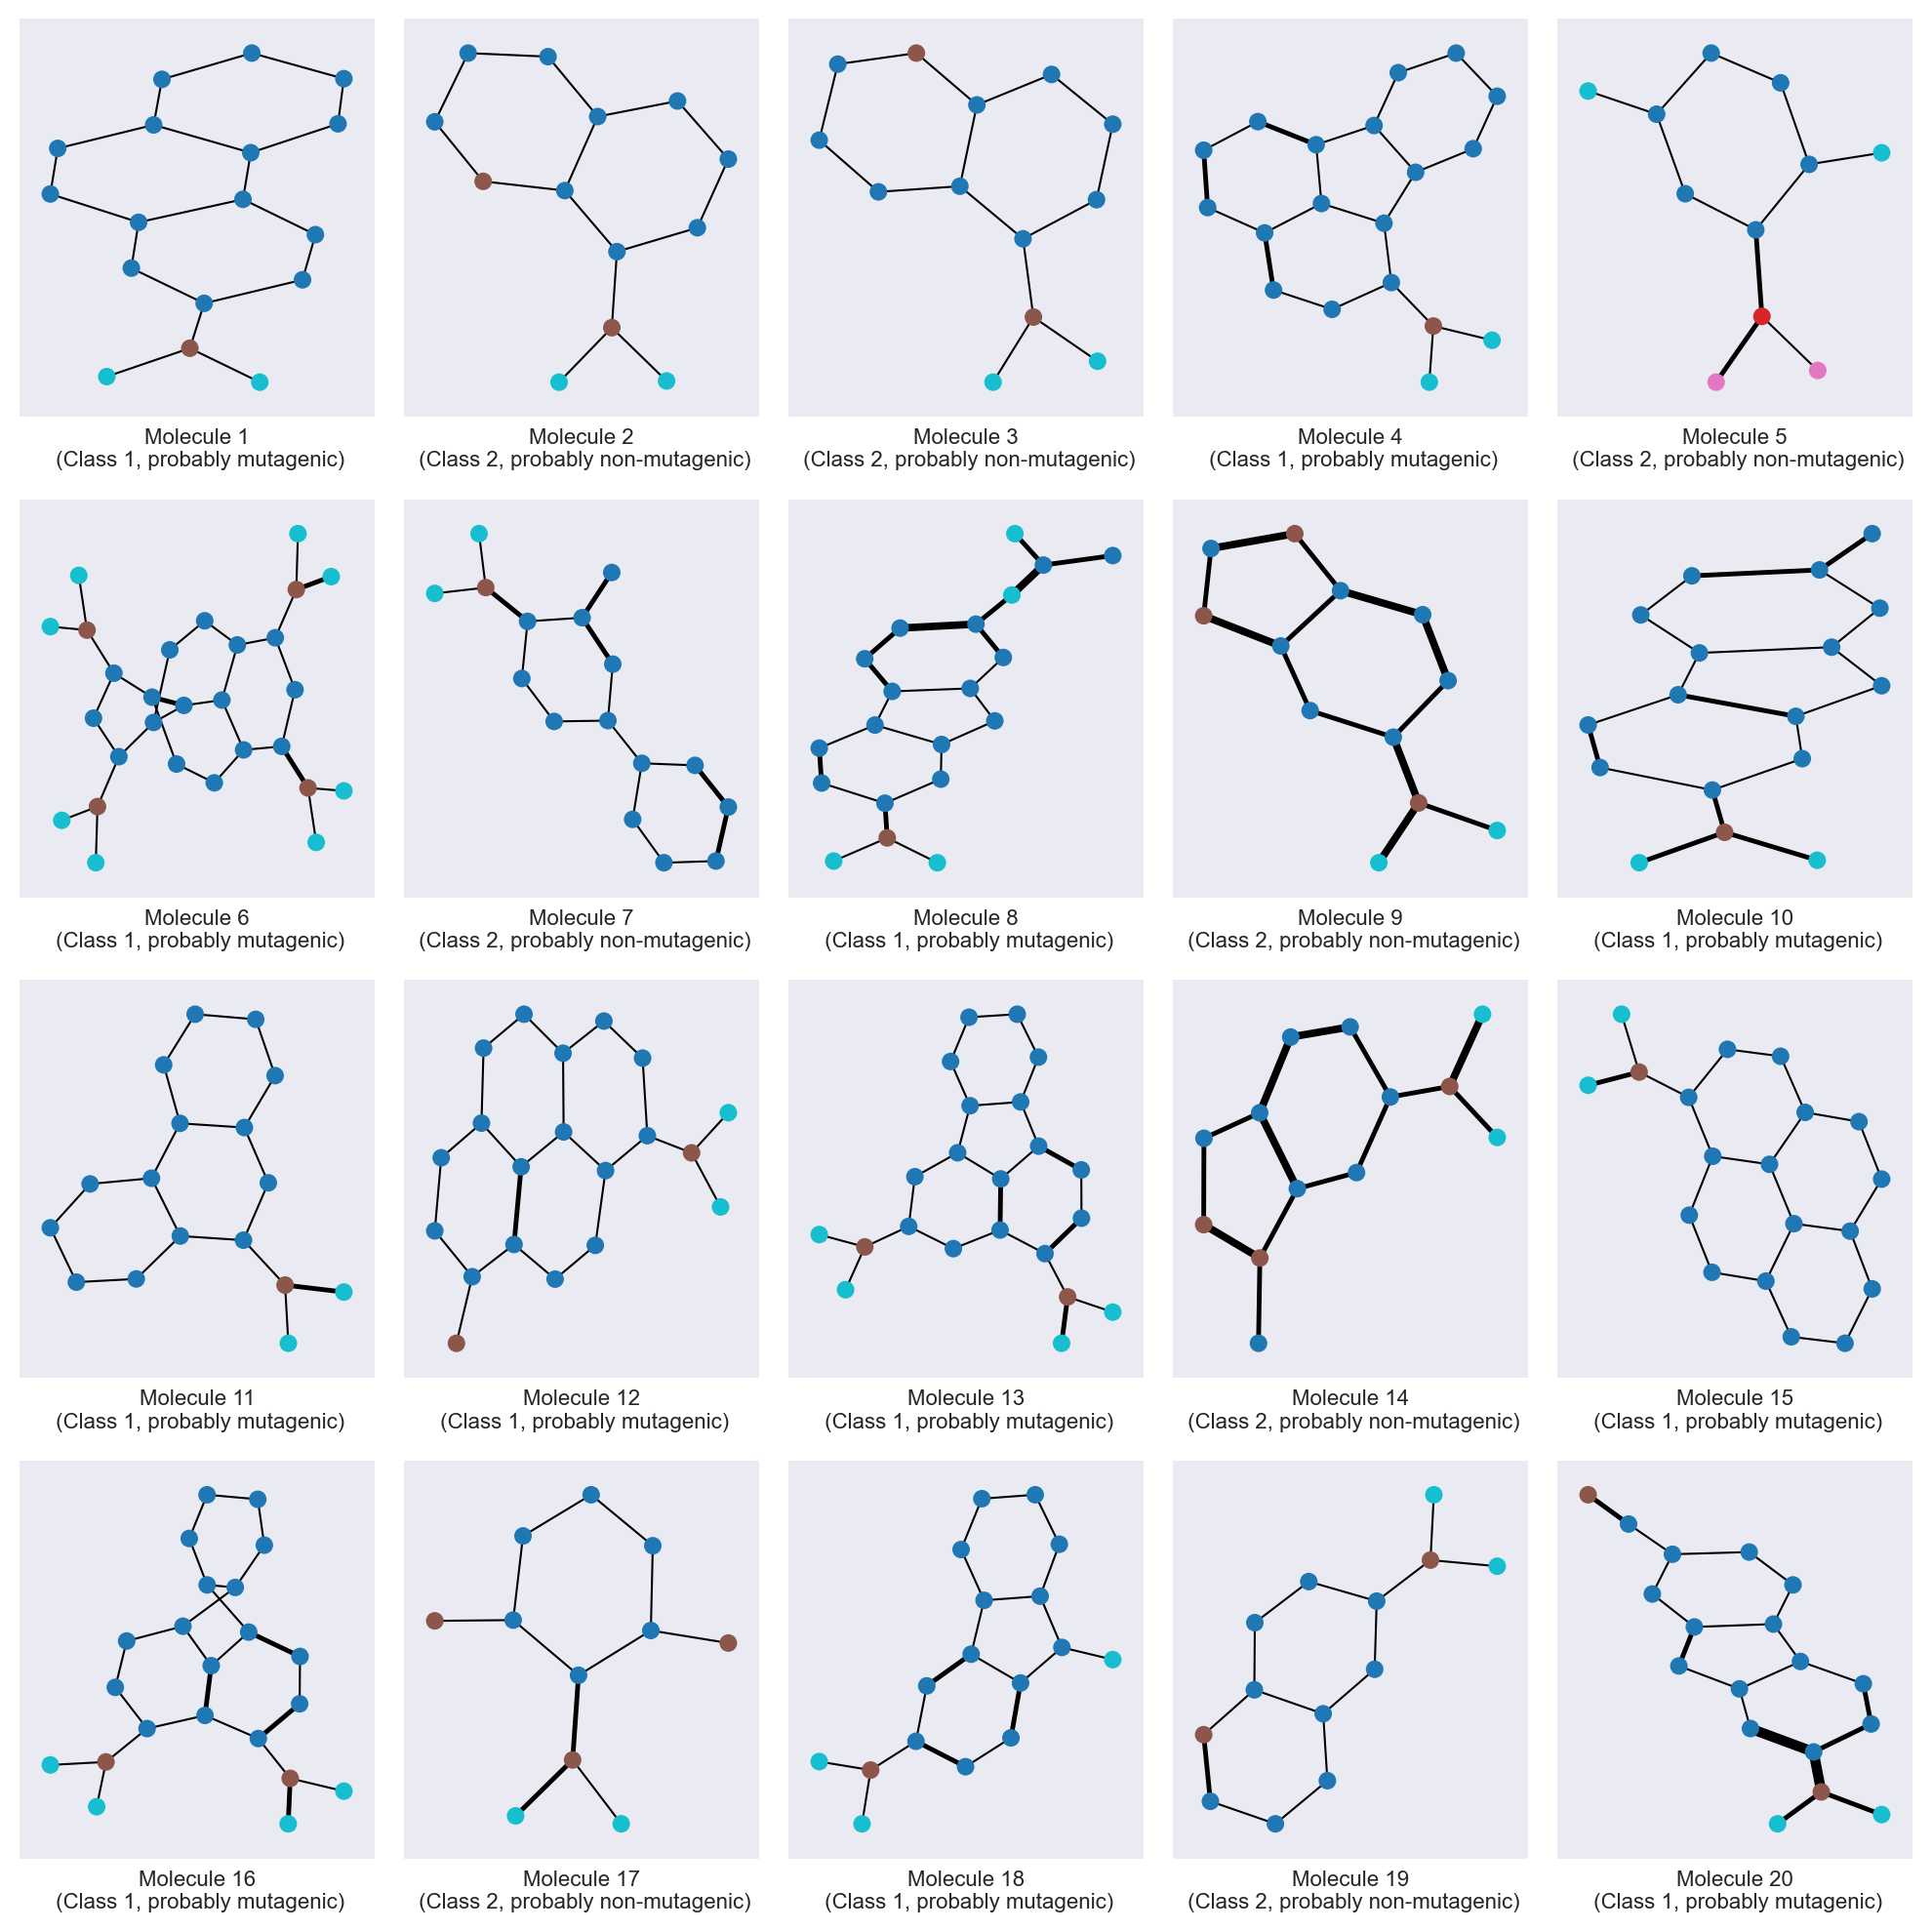

In [9]:
# draw graph of 20 first molecules
_,_ = utils.draw_molecules(
    adjacency_matrices=adjacency_matrices[:20],
    node_features=node_features,
    edge_features=edges_attr,
    class_y=class_y,
)

In the next notebook, we will train a GCN model on this dataset.
See {ref}`section:gcn`